# Plot within-gene mutation spectra and coverages

Useful for comparing genes.

In [1]:
%run "Header.ipynb"
%run "LoadMutationJSONData.ipynb"
%run "GeneUtils.ipynb"

## Define utility functions for plotting

In [2]:
def init_cp(strand):
    """Returns the CP of the leftmost position in a gene. Arguably too simple for its own good."""
    if strand == "+":
        return 1
    else:
        return 3

def move_cp_right(cp, strand):
    """Moves a given CP value right by 1. This is really just basic modulo arithmetic, but I wrote
       it out very explicitly to make this easier to read.
    """
    if strand == "+":
        if cp == 3:
            return 1
        else:
            return cp + 1
    else:
        if cp == 1:
            return 3
        else:
            return cp - 1
        
def get_label(p, cp, leftend, strand):
    """Defines the label we assign to a given point in a mutation spectrum / coverage plot.
    
    This label, in turn, impacts the legend shown by matplotlib.
    """
    formatcp = lambda n: "Codon Position {}".format(n)
    
    # If we assign a label to every datapoint, then the duplicate labels show up in the legend.
    # To avoid this, we just only assign labels to the first point of CP 1, then the first point
    # of CP 2, then the first point of CP 3 -- so the legend only has the three unique colors, as desired.
    # See https://stackoverflow.com/a/19386045.
    if strand == "+":
        # For positive-strand genes, we can just take the first three points (going from left to right)'s
        # labels -- these will have labels CP 1, 2, 3.
        return "" if (p - leftend >= 3) else formatcp(cp)
    else:
        # For negative-strand genes, life is a bit harder. We could just take the first three points,
        # similarly to how positive-strand genes are handled above, but the problem with this is that
        # matplotlib is sensitive to label orderings... so then the label is flipped, and CP 3 is shown
        # first, then CP 2, then CP 1. Which is not desirable.
        #
        # We correct this by noting that the earliest occurrence of CP 1 from the left is when
        # (p - leftend) == 2. The earliest occurrence of CP 2 after that is when (p - leftend == 4).
        # And the earliest occurrence of CP 3 after that is when (p - leftend == 6). We can thus set up
        # some simple-ish rules that'll let us extract the CP 1/2/3 labels in order.
        #
        # (The reason this uses >= 7 as the first conditional is so that we can fail quickly for
        # higher positions in the gene, using boolean short-circuiting.)
        #
        # (...I guess this will fail, producing legends without enough detail, if the gene doesn't have
        # at least 7 characters. I think that is not a very likely scenario, and it wouldn't be a very
        # big problem anyway.)
        return "" if (p - leftend >= 7 or (p - leftend) in [0, 1, 3, 5]) else formatcp(cp)

In [3]:
def plot_gene_mutation_spectrum(seq, leftend, rightend, strand, ax, cutoff=None):
    """leftend must be < rightend -- so if this is a reverse gene,
    the end position should still be leftend, I think.
    
    "cutoff" can optionally be a float. If cutoff is not None, then this'll print out
    information about the number of positions where the percentage of mismatches is >= cutoff.
    (Mostly useful for adding to figure captions...)
    """
    gene_positions = range(leftend, rightend + 1)
    if len(gene_positions) % 3 != 0:
        raise ValueError("Gene length not divisible by 3")
        
    # Use strand to influence whether this goes 123123123 or 321321321
    cp = init_cp(strand)
    
    max_mutation_pct = float("-inf")
    
    num_called_mutations = 0
    called_mutations_in_cps = [0, 0, 0]
    called_mutations_pcts = []
    called_mutations_positions = []
    
    # We adopt the strategy here of calling .scatter() for each data point to plot, rather than
    # building up lists of x-axis, y-axis, and color values and plotting that. See e.g.
    # https://stackoverflow.com/questions/42180475#comment71523984_42180475 for documentation on this.
    
    for p in gene_positions:
        sp = str(p)
        cov = seq2pos2mismatchct[seq][sp] + seq2pos2matchct[seq][sp]
        pct = seq2pos2mismatchct[seq][sp] / cov
        max_mutation_pct = max(max_mutation_pct, pct)
        
        label = get_label(p, cp, leftend, strand)
        
        bc = BORDERCOLOR
        # little test -- look for the two diff-strain (?) positions in CAMP
        if seq == "edge_6104" and (p == 986217 or p == 986215):
            bc = "#ff0000"
        ax.scatter(p, pct, c=cp2color[cp], label=label, edgecolor=bc)
        
        cp = move_cp_right(cp, strand)

        if cutoff is not None and pct >= cutoff:
            num_called_mutations += 1
            called_mutations_in_cps[cp - 1] += 1
            called_mutations_pcts.append(pct)
            called_mutations_positions.append(p)
    
    if cutoff is not None:
        print("{} / {} positions have a mismatch rate >= the cutoff of {}".format(
            num_called_mutations, len(gene_positions), cutoff
        ))
        # Avoid printing details if no "mutations" were identified here -- mean() will throw an error, at least
        # as of writing, if passed an empty collection.
        if num_called_mutations > 0:
            print("{} mutations in CP 1; {} mutations in CP 2; {} mutations in CP 3.".format(*called_mutations_in_cps))
            print("Average mutation rate among these {} positions is {:.2f}%.".format(
                num_called_mutations, mean(called_mutations_pcts) * 100
            ))
            print("These exact positions are {}".format(called_mutations_positions))

    ax.set_title("Mutation spectrum")
    # Hide x-axis label for now, since we don't need this when tiling this plot on top of a coverage plot
#     ax.set_xlabel("Sequence position")
    # https://stackoverflow.com/a/27474400 -- need to use raw string
    # https://stackoverflow.com/a/23856968 -- can use \mathrm{} to substitute for \text{}
    ax.set_ylabel(r"$\dfrac{\mathrm{Mismatches}}{\mathrm{Mismatches + Matches}}$")
    
    ax.set_ylim(0)
    # Make low-mutation-rate genes have more granularity in the y-axis tick labels (matplotlib
    # can do stuff like just show 0% for all ticks if we use decimals=0)
    # The reason we don't use decimals=None, the default (where we make matplotlib pick the level of granularity),
    # is that that seems to use too many decimals for our purposes (the docs admit that decimals=None has some
    # limitations: https://github.com/matplotlib/matplotlib/blob/22258133da1fd25e38a519b8fe1314d1ba513990/lib/matplotlib/ticker.py#L1624-L1626)
    # This approach isn't perfect either, but it's good enough. (TODO: figure out the optimal way to do this?)
    if max_mutation_pct < 0.005:
        decimals = 2
    elif max_mutation_pct < 0.05:
        decimals = 1
    else:
        decimals = 0
        
    ax.legend()
    print("Maximum mutation rate is {:.2f}%".format(max_mutation_pct * 100))
    # Disable "offset" on the x-axis. This prevents matplotlib from replacing literal sequence positions with
    # smaller numbers and then adding a "+1.21e6" off to the side of the axis (which is... a lot more confusing
    # for this particular application than just listing the actual sequence positions). Doing this *after* the
    # percentage thing below doesn't seem to work, but doing it up here works. I dunno, matplotlib is hard.
    # See https://stackoverflow.com/a/28373421.
    ax.ticklabel_format(useOffset=False)
    
    # Make the y-axis show percentages: based on
    # https://old.reddit.com/r/learnpython/comments/7adhnk/matplotlib_setting_y_axis_labels_to_percent_yaxis/dp93fwq/
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=decimals))
    
    # Use thousands separator on the x-axis
    use_thousands_sep(ax.get_xaxis())

In [4]:
def plot_gene_coverage(seq, leftend, rightend, strand, ax):
    gene_positions = range(leftend, rightend + 1)
    if len(gene_positions) % 3 != 0:
        raise ValueError("Gene length not divisible by 3")

    cp = init_cp(strand)
    
    min_cov = float("inf")
    all_covs = []
    for p in gene_positions:
        cov = seq2pos2totalcov[seq][str(p)]
        all_covs.append(cov)
        min_cov = min(min_cov, cov)
        label = get_label(p, cp, leftend, strand)
        ax.scatter(p, cov, c=cp2color[cp], label=label, edgecolor=BORDERCOLOR)
        cp = move_cp_right(cp, strand)
    
    print("The lowest-coverage position in this entire gene has coverage {:,}x.".format(min_cov))
    print("This gene has an average coverage of {:,}x.".format(mean(all_covs)))
    print("...(The sum of all positions' coverages is {:,}x, for reference.)".format(sum(all_covs)))
    ax.set_title("Coverage")
    ax.set_xlabel("Sequence position")
    ax.set_ylabel("Mismatches + Matches")
    ax.legend()
    ax.ticklabel_format(useOffset=False)
    use_thousands_sep(ax.get_xaxis())
    use_thousands_sep(ax.get_yaxis())

In [5]:
def mutation_spectrum_and_coverage_plots(seq, gene_num, cutoff=None):
    """Plots a gene's mutation spectrum and coverage.
    
        seq: str
        
        gene_num: int
            1-indexed gene number in the Prodigal .sco file for the specified sequence (seq).
        
        cutoff: float (optional)
            This is passed to plot_gene_mutation_spectrum() -- see docs of that.
    """
    genes_df = parse_sco("../seqs/genes/{}.sco".format(seq))
    
    # Select gene by its index in the dataframe (which is the 1-indexed number Prodigal assigned to it)
    gene_data = genes_df.loc[gene_num]
    
    leftend = gene_data["LeftEnd"]
    rightend = gene_data["RightEnd"]
    strand = gene_data["Strand"]
    
    fig, (ax1, ax2) = pyplot.subplots(2)
    plot_gene_mutation_spectrum(seq, leftend, rightend, strand, ax1, cutoff=cutoff)
    plot_gene_coverage(seq, leftend, rightend, strand, ax2)
    fig.suptitle(
        "{}\nGene #{}: left end {:,}, right end {:,}, strand {}".format(
            seq2name[seq], gene_num, leftend, rightend, strand
        ),
        fontsize="16",
        y=0.955
    )
    fig.set_size_inches(15, 13)
    fig.savefig("figs/{}_gene{}.png".format(seq, gene_num), bbox_inches="tight")

## Plot genes

### G1 in CAMP

34 / 1149 positions have a mismatch rate >= the cutoff of 0.14
30 mutations in CP 1; 2 mutations in CP 2; 2 mutations in CP 3.
Average mutation rate among these 34 positions is 16.00%.
These exact positions are [1209001, 1209010, 1209022, 1209058, 1209104, 1209115, 1209121, 1209126, 1209133, 1209136, 1209142, 1209145, 1209148, 1209154, 1209205, 1209241, 1209265, 1209266, 1209297, 1209322, 1209325, 1209337, 1209400, 1209403, 1209418, 1209421, 1209424, 1209523, 1209577, 1209610, 1209697, 1209700, 1209757, 1209796]
Maximum mutation rate is 16.22%
The lowest-coverage position in this entire gene has coverage 4,381x.
This gene has an average coverage of 4,519.933855526545x.
...(The sum of all positions' coverages is 5,193,404x, for reference.)


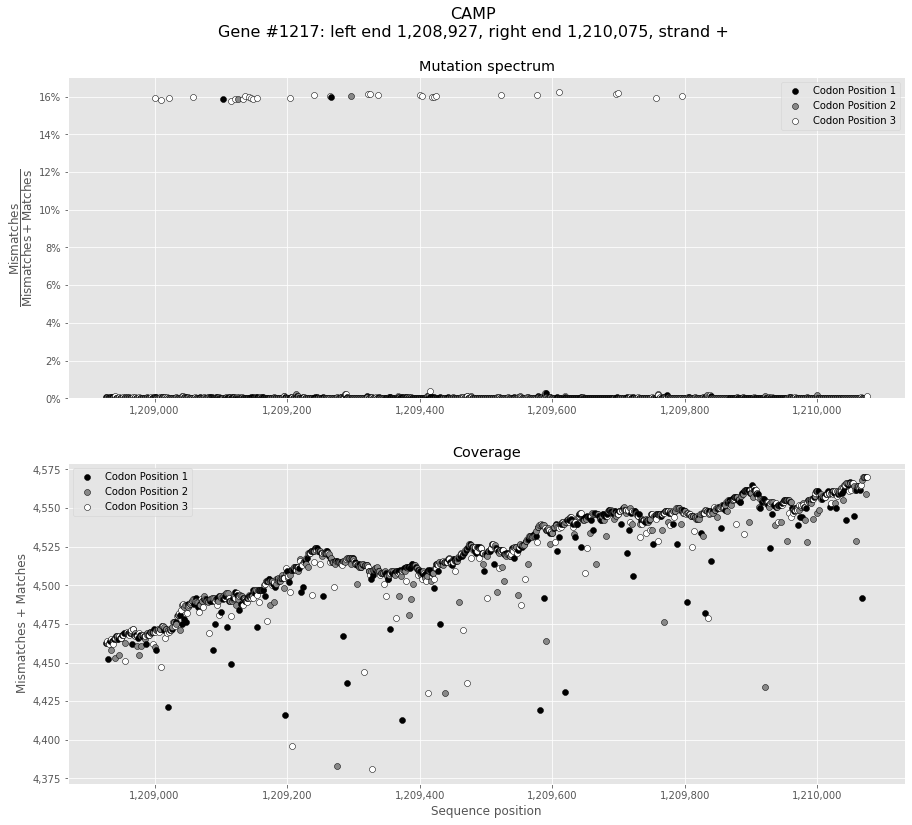

In [6]:
# We pass cutoff=0.14 so the function will count the number of positions above a 14% mutation rate
# The "center" is obvs closer to 16%, but to be careful and make sure we count everything we set it to 14%

# To count positions with mutation frequency of > 0.5%, set cutoff=0.005. 
mutation_spectrum_and_coverage_plots("edge_6104", 1217, cutoff=0.14)

### Highest-mutation-rate genes in all three genomes

Maximum mutation rate is 0.23%
The lowest-coverage position in this entire gene has coverage 4,137x.
This gene has an average coverage of 4,291.142947501581x.
...(The sum of all positions' coverages is 6,784,297x, for reference.)
Maximum mutation rate is 8.14%
The lowest-coverage position in this entire gene has coverage 1,225x.
This gene has an average coverage of 1,296.7342657342658x.
...(The sum of all positions' coverages is 556,299x, for reference.)
Maximum mutation rate is 0.67%
The lowest-coverage position in this entire gene has coverage 3,300x.
This gene has an average coverage of 3,427.7105855855857x.
...(The sum of all positions' coverages is 3,043,807x, for reference.)


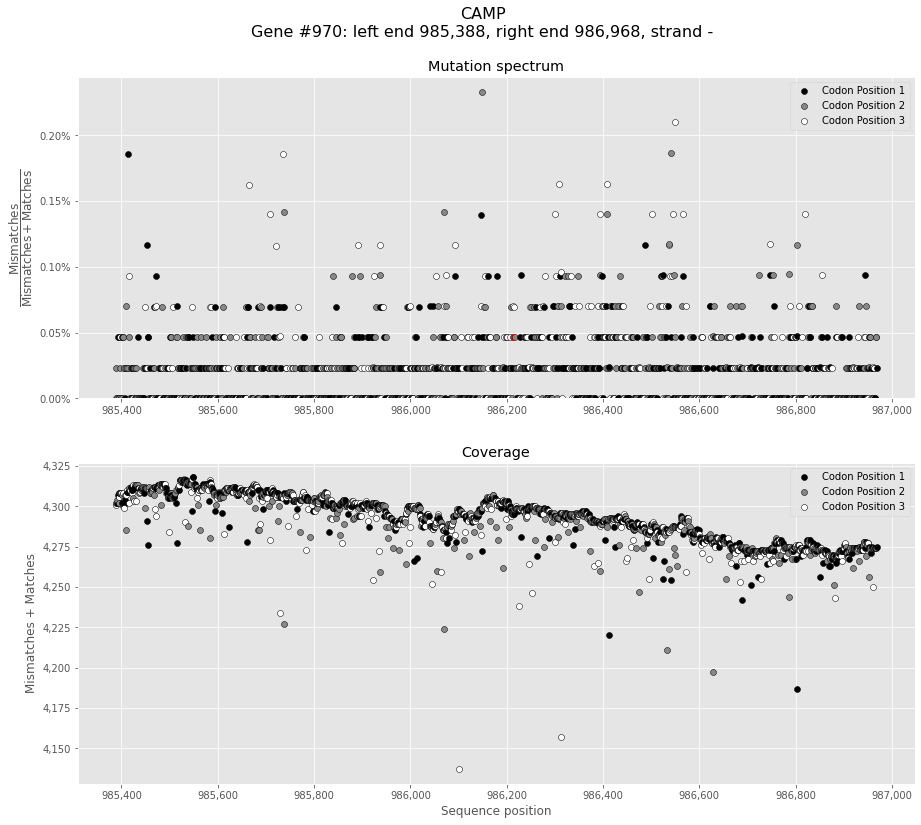

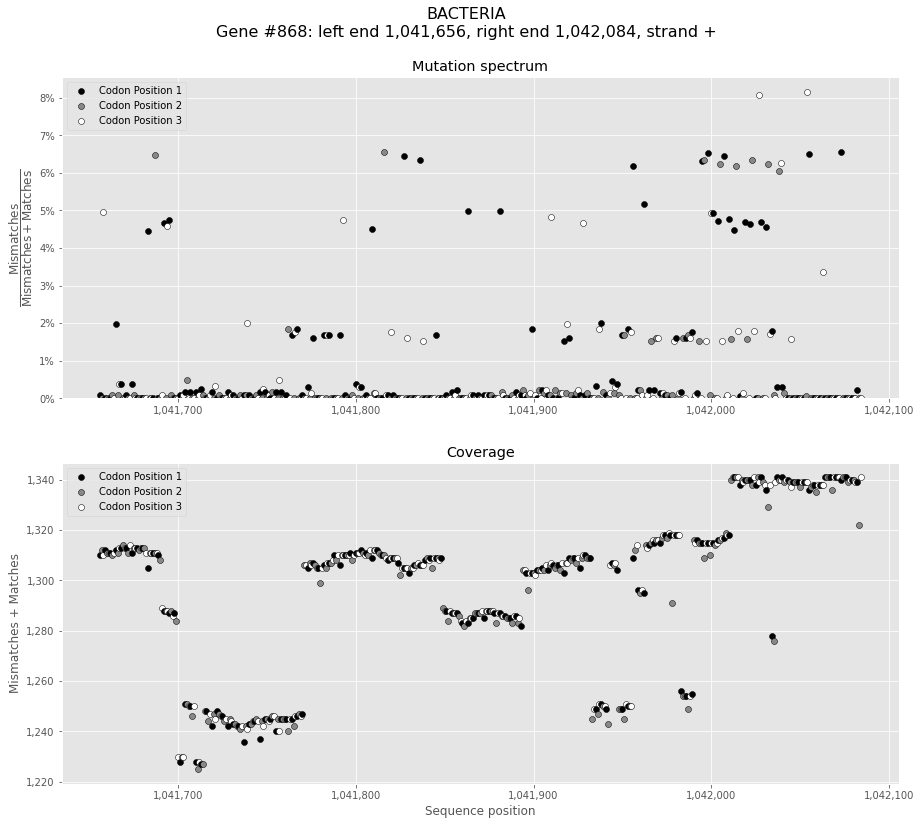

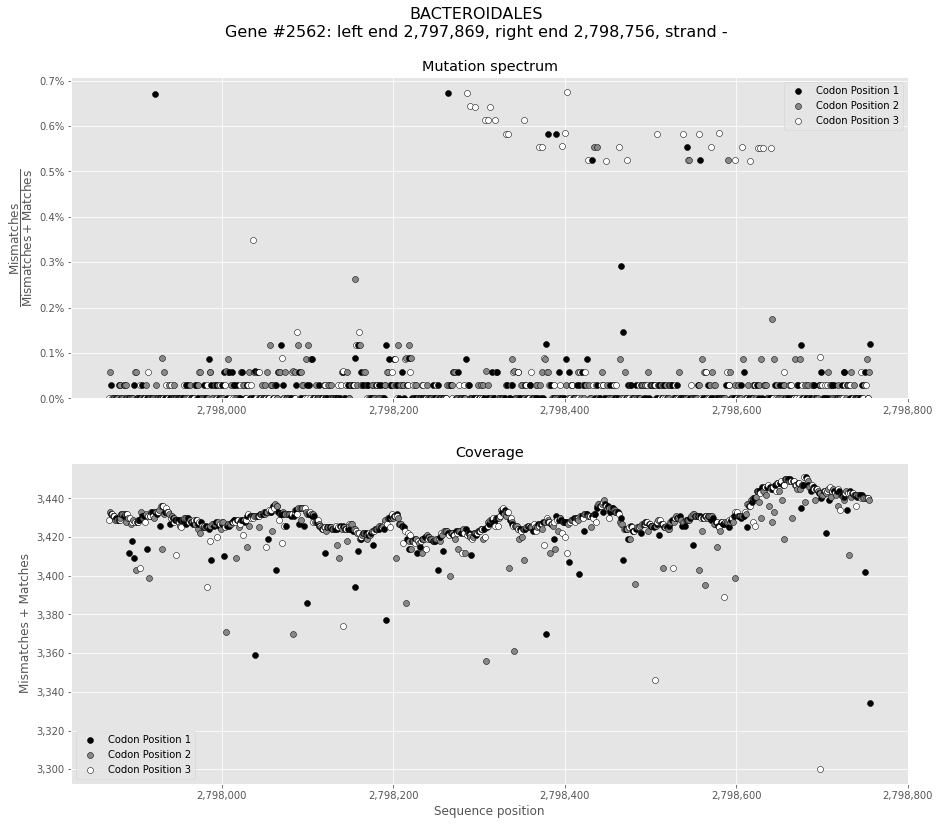

In [7]:
# NOTE: this is negative, so CP 1 and 3 should be flipped
mutation_spectrum_and_coverage_plots("edge_6104", 970)
mutation_spectrum_and_coverage_plots("edge_1671", 868)
mutation_spectrum_and_coverage_plots("edge_2358", 2562)

### Other tests

0 / 1554 positions have a mismatch rate >= the cutoff of 0.4
Maximum mutation rate is 0.22%
The lowest-coverage position in this entire gene has coverage 4,452x.
This gene has an average coverage of 4,587.722007722008x.
...(The sum of all positions' coverages is 7,129,320x, for reference.)


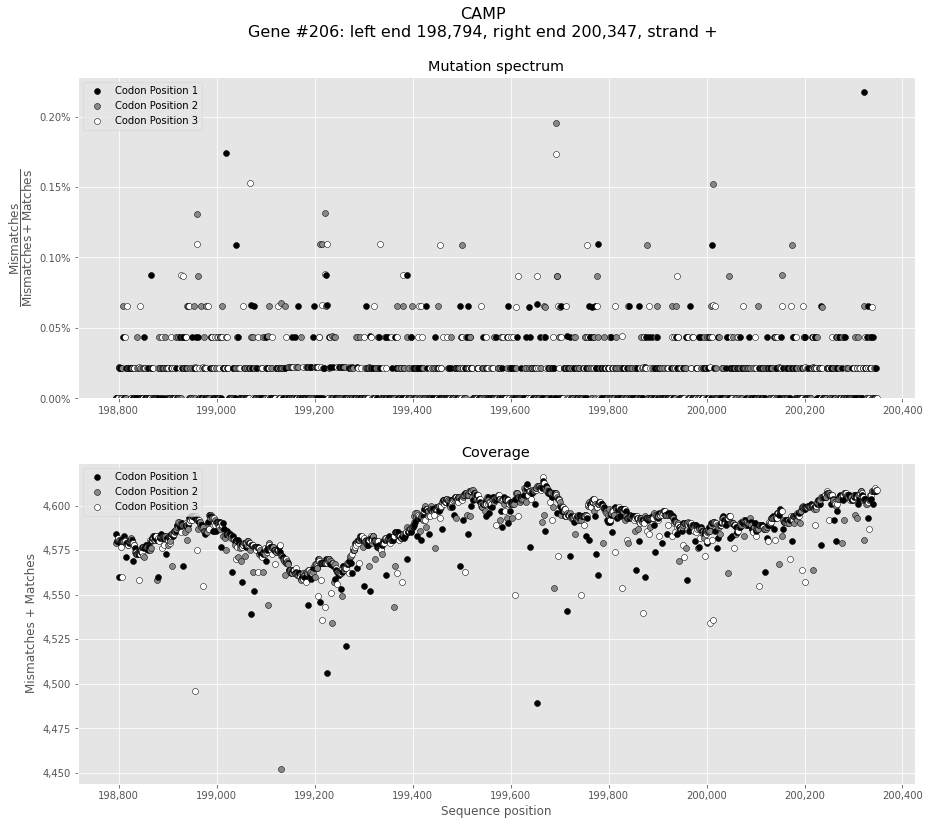

In [8]:
# The gene we're going to plot here is number 206.
mutation_spectrum_and_coverage_plots("edge_6104", 206, cutoff=0.4)

Maximum mutation rate is 0.41%
The lowest-coverage position in this entire gene has coverage 4,662x.
This gene has an average coverage of 4,844.389513108615x.
...(The sum of all positions' coverages is 1,293,452x, for reference.)


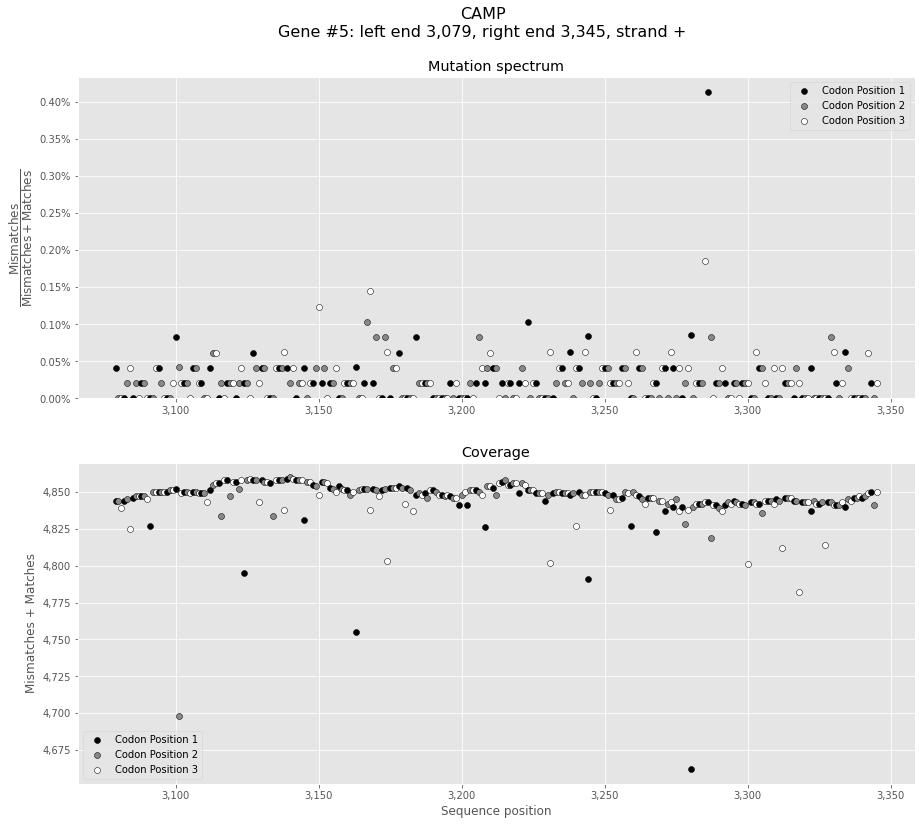

In [9]:
# The first forward strand gene found by prodigal, for comparison to the outliers
# >5_3079_3345_+
mutation_spectrum_and_coverage_plots("edge_6104", 5)

Maximum mutation rate is 0.25%
The lowest-coverage position in this entire gene has coverage 4,738x.
This gene has an average coverage of 4,839.20581655481x.
...(The sum of all positions' coverages is 2,163,125x, for reference.)


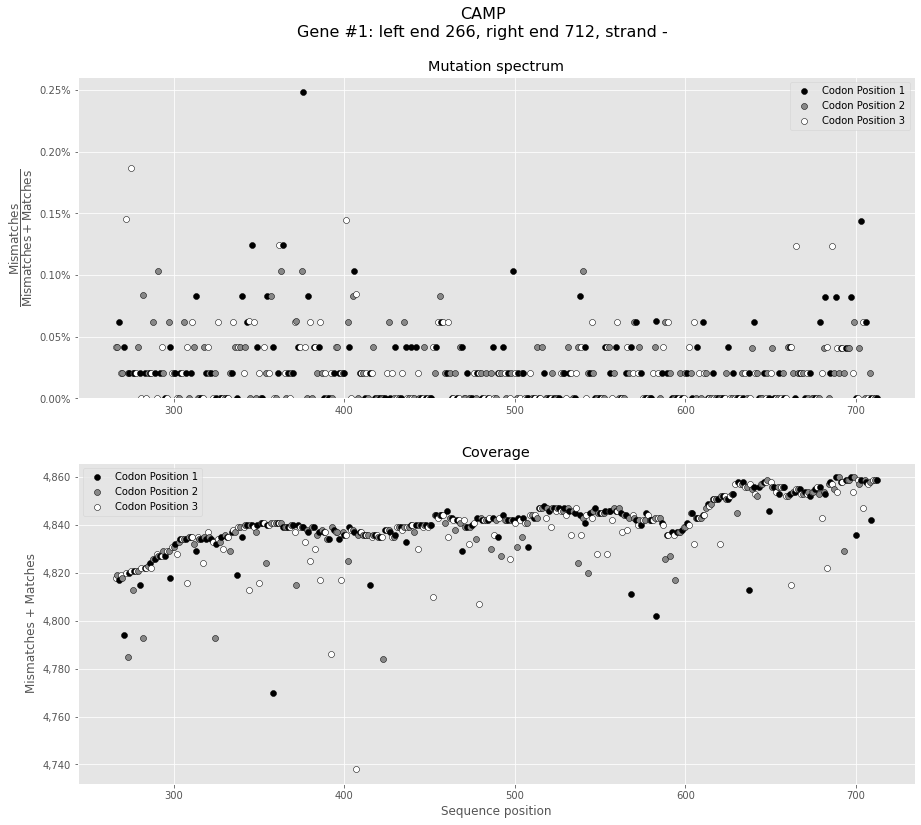

In [10]:
# The first gene, just for fun
# NOTE: This gene is tagged as negative so CPs 1 and 3 should be inverted in the coloring - TODO support that...
mutation_spectrum_and_coverage_plots("edge_6104", 1)